In [1]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from tqdm import tqdm
import random

# set the seed for reproducibility
SEED = 42
np.random.seed(SEED)

from utils import *
from gen import test, random_search, true_random_search, true_random_nsteps


In [26]:
env = gym.make(
    "MiniHack-ExploreMaze-Hard-Mapped-v0",
    observation_keys=("chars", "pixel"),
    #des_file = "simple_maze.des",
    max_episode_steps=10000,
)
state = env.reset(seed=SEED)
env.render()

TypeError: NLE.reset() got an unexpected keyword argument 'seed'

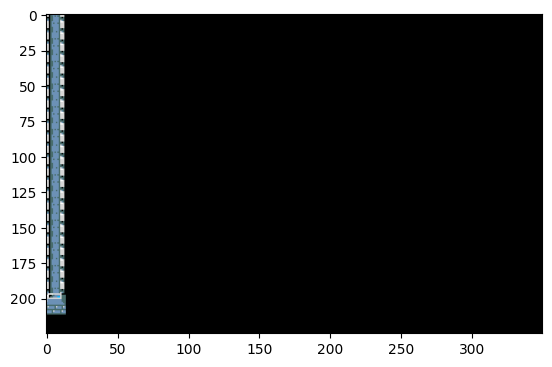

In [3]:
plt.imshow(state['pixel'][75:300, 450:800])

In [4]:
game_map = state['chars']
game = state['pixel']
start = get_player_location(game_map)
target = get_target_location(game_map)

In [5]:
test()

test


In [6]:
path1 = random_search(game_map, start, target)
len(path1)

Target found!
target (12, 14)
target (11, 14)
target (10, 14)
target (9, 14)
target (8, 14)
target (7, 14)
target (6, 14)
target (5, 14)
target (4, 14)
target (4, 13)
target (5, 13)
target (5, 12)
target (5, 11)
target (5, 10)
target (5, 9)
target (5, 8)
target (6, 8)
target (7, 8)
target (7, 7)
target (7, 6)
target (6, 6)
target (5, 6)
target (5, 5)
target (5, 4)
target (6, 4)
target (7, 4)
target (7, 3)
target (7, 2)
target (6, 2)
target (5, 2)
target (5, 1)
target (6, 1)
target (7, 1)
target (8, 1)
target (9, 1)
target (10, 1)
target (11, 1)


37

In [7]:
path = true_random_nsteps(game_map, start, target)
len(path)

101

In [8]:
path

[(11, 1),
 (10, 1),
 (11, 1),
 (10, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (10, 1),
 (10, 2),
 (10, 3),
 (10, 4),
 (9, 4),
 (10, 4),
 (10, 3),
 (10, 4),
 (11, 4),
 (11, 3),
 (11, 4),
 (12, 4),
 (11, 4),
 (12, 4),
 (11, 4),
 (11, 3),
 (11, 2),
 (11, 3),
 (11, 4),
 (11, 3),
 (11, 2),
 (11, 1),
 (10, 1),
 (9, 1),
 (8, 1),
 (8, 2),
 (7, 2),
 (8, 2),
 (9, 2),
 (8, 2),
 (9, 2),
 (8, 2),
 (7, 2),
 (6, 2),
 (6, 1),
 (5, 1),
 (6, 1),
 (5, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (6, 1),
 (6, 2),
 (6, 1),
 (6, 2),
 (7, 2),
 (8, 2),
 (8, 1),
 (8, 2),
 (8, 1),
 (8, 2),
 (7, 2),
 (6, 2),
 (5, 2),
 (6, 2),
 (6, 1),
 (5, 1),
 (4, 1),
 (5, 1),
 (5, 2),
 (5, 1),
 (5, 2),
 (6, 2),
 (7, 2),
 (8, 2),
 (9, 2),
 (10, 2),
 (11, 2),
 (11, 3),
 (11, 2),
 (10, 2),
 (11, 2),
 (11, 3),
 (11, 4),
 (12, 4),
 (11, 4),
 (12, 4),
 (13, 4),
 (12, 4),
 (13, 4),
 (12, 4),
 (11, 4),
 (10, 4),
 (10, 3),
 (11, 3),
 (11, 2),
 (11, 1),
 (11, 2),
 (10, 2),
 (10, 1),
 (10, 2),
 (10, 1),
 (11, 1)]

In [9]:
# print last element of path
path[-1]

(11, 1)

In [10]:
target

(12, 14)

In [19]:
# this is manhattan distance from the last element of the path to the target
fitness_function = lambda path: abs(path[-1][0] - target[0]) + abs(path[-1][1] - target[1])

a = (0, -1)
b = (0, 1)
c = (1, 0)      
d = (-1, 0)

ACTIONS = [a, b, c, d]

def modify_action(t1, t2):
    """Sum two tuples"""
    return (t1[0] + t2[0], t1[1] + t2[1])

def is_crossoverable(action1, action2):
    # if action 1 and action 2 are oblique, return False
    dx = abs(action1[0] - action2[0])
    dy = abs(action1[1] - action2[1])
    # return false if the two components are changing together and > 1
    if dx > 0 and dy > 0:
        return False
    else:
        return True

def crossover(path1, path2):
    """Crossover two paths"""
    # randomly select a crossover point
    i = np.random.randint(1, min(len(path1), len(path2)))
    while not is_crossoverable(path1[i-1], path2[i]):
        i = np.random.randint(1, min(len(path1), len(path2)))

    # return the two paths joined at the crossover point
    return path1[:i] + path2[i:]
     

def mutate(path, mutation_rate=0.05):
    """Mutate a path"""
    # randomly select n postions to mutate
    idxs = random.choices(range(len(path)), k=5)
    # randomly select new actions for each position and replace
    # TODO?  implement controls on move validity
    for idx in idxs:
        path[idx] = modify_action(path[idx], random.choice(ACTIONS))
    return path

MAX_GENERATIONS = 1000
MAX_INDIVIDUALS = 100

best_scores =[]
best_paths = []

# create a list of individuals, starting with random moves (illegal actions filtered out)
print("> Creating initial population...")
individuals = [true_random_nsteps(game_map, start, target) for _ in range(MAX_INDIVIDUALS)]
best_fitness = np.inf

# create a list of tuples (individual, fitness)
print("> Evolving...")
for generation in tqdm(range(MAX_GENERATIONS), postfix=f'best score: {best_fitness:.2f}'):
    generation_scores = []
    
    fitnesses = [fitness_function(individual) for individual in individuals]
    generation_scores.append(min(fitnesses))

    # this is a list of tuples (individual, fitness). individual is a list of moves
    population = list(zip(individuals, fitnesses))

    # sorting the population by best fitness (lower is better)
    population.sort(key=lambda x: x[1])
    
    # take 2 best individuals -> maybe can be replaced with probability distribution based on fitness
    # also roulette wheel selection.
    child1, child2 = population[0], population[1]
    offspring = [crossover(child1[0], child2[0]) for _ in range(MAX_INDIVIDUALS)]
    #offspring = [mutate(child) for child in offspring]
    individuals = offspring
    best_fitness = population[0][1]
    best_scores.append(population[0][1])    
    best_paths.append(population[0][0])

    

> Creating initial population...
> Evolving...


100%|██████████| 1000/1000 [00:00<00:00, 4191.54it/s, best score: inf]


In [15]:
start

(11, 1)

In [18]:
path

[(12, 1),
 (11, 1),
 (11, 2),
 (10, 2),
 (11, 2),
 (11, 1),
 (10, 1),
 (9, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (10, 2),
 (10, 1),
 (11, 1),
 (12, 2),
 (11, 2),
 (9, 2),
 (9, 1),
 (8, 1),
 (8, 1),
 (6, 1),
 (7, 1),
 (7, 2),
 (6, 2),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 5),
 (5, 6),
 (6, 6),
 (5, 6),
 (6, 6),
 (7, 6),
 (8, 6),
 (9, 6),
 (9, 7),
 (9, 6),
 (8, 6),
 (9, 6),
 (8, 6),
 (7, 6),
 (6, 6),
 (7, 6),
 (6, 6),
 (7, 6),
 (8, 6),
 (9, 6),
 (8, 6),
 (7, 6),
 (6, 7),
 (7, 6),
 (8, 6),
 (7, 6),
 (8, 6),
 (7, 6),
 (8, 6),
 (7, 6),
 (6, 6),
 (5, 6),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 9),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 11),
 (5, 12),
 (5, 11),
 (5, 12),
 (5, 13),
 (6, 13),
 (7, 13),
 (7, 14),
 (6, 14),
 (6, 13),
 (6, 14),
 (7, 14),
 (7, 13),
 (7, 14),
 (7, 13),
 (7, 14),
 (7, 13),
 (6, 13),
 (7, 13),
 (7, 14),
 (8, 14),
 (8, 13),
 (8, 12),
 (8, 13),
 (9, 14)]

In [13]:
actions_from_path(start, path)

Exception: x and y can't change at the same time. oblique moves not allowed!

TypeError: NLE.reset() got an unexpected keyword argument 'seed'

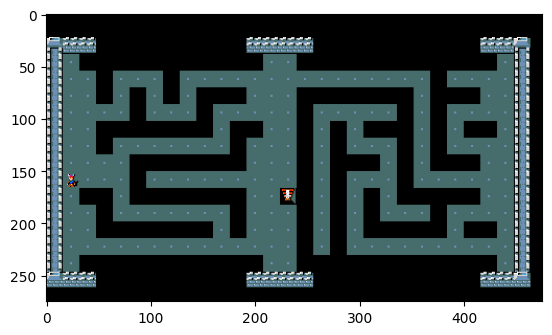

In [23]:
image = plt.imshow(game[25:300, :475])
for generation, path in enumerate(best_paths):
    start = path[0]
    path = path[1:]
    state=env.reset(seed=42)
    actions = actions_from_path(start, path)
    
    for action in actions:
        s, _, _, _ = env.step(action)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        image.set_data(s['pixel'][25:300, :475])
    
    plt.title(f"Generation {generation}")
    env.reset()